In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
import numpy as np

In [0]:
# Training settings
args_batch_size = 64
args_test_batch_size = 1000
args_epochs = 20
args_lr = 0.001
args_momentum = 0.9
args_decay = 5e-4
args_seed = 1
args_log_interval = 2500
args_no_cuda = False
args_cuda = not args_no_cuda and torch.cuda.is_available()

torch.manual_seed(args_seed)
if args_cuda:
    torch.cuda.manual_seed(args_seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args_cuda else {}
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO: define your network here 
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # TODO
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
if args_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args_lr, momentum=args_momentum, weight_decay=args_decay)

train_loss_list = []
test_loss_list  = []
valid_acc_list  = []

def train(epoch):
    model.train()
    loss_sum = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        # use cross_entropy here, since there is no softmax function in my last layer
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args_log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
        
        loss_sum += loss.data
        total += 1
        
    train_loss_list.append(loss_sum / total)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # preserve the accuracy for plot and comparison
    test_loss_list.append(test_loss)
    valid_acc_list.append(100. * correct / len(test_loader.dataset))


for epoch in range(1, args_epochs + 1):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.291898
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.341178
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.797303
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.295773
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.592214

Test set: Average loss: 1.6617, Accuracy: 3858/10000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.578823
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.669775
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.316223
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.647767
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.775793

Test set: Average loss: 1.5162, Accuracy: 4506/10000 (45%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.385454
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.620360
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.602592
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.716719
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.167396

Test set: Average loss: 1.4890, Accuracy: 4257/10000 (43%)

Train 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


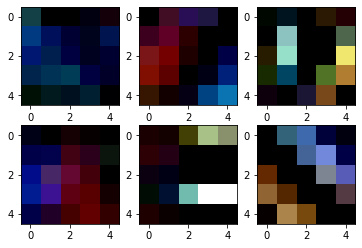

In [0]:
# Visualize the filters learned in the first convolutional layer

conv1_weight = model.conv1.weight.detach().cpu().numpy()

plt.figure()
plt.subplot(231)
plt.imshow(conv1_weight[0, ...].T)
plt.subplot(232)
plt.imshow(conv1_weight[1, ...].T)
plt.subplot(233)
plt.imshow(conv1_weight[2, ...].T)
plt.subplot(234)
plt.imshow(conv1_weight[3, ...].T)
plt.subplot(235)
plt.imshow(conv1_weight[4, ...].T)
plt.subplot(236)
plt.imshow(conv1_weight[5, ...].T)

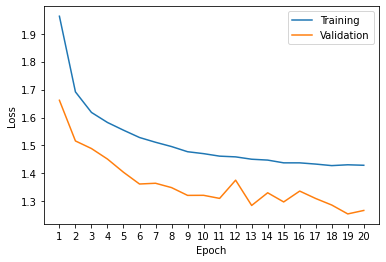

In [0]:
plt.plot(np.arange(1, args_epochs+1), train_loss_list, label='Training')
plt.plot(np.arange(1, args_epochs+1), test_loss_list, label='Validation')
plt.xticks(np.arange(1, args_epochs+1))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

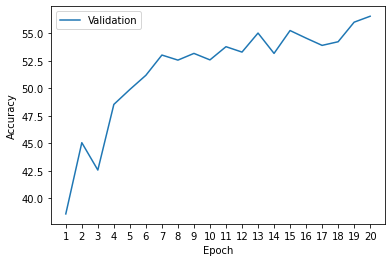

In [0]:
plt.plot(np.arange(1, args_epochs+1), valid_acc_list, label='Validation')
plt.xticks(np.arange(1, args_epochs+1))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# Weight initialization

# Training settings
args_batch_size = 64
args_test_batch_size = 1000
args_epochs = 20
args_lr = 0.001
args_momentum = 0.9
args_decay = 5e-4
args_seed = 1
args_log_interval = 2500
args_no_cuda = False
args_cuda = not args_no_cuda and torch.cuda.is_available()

torch.manual_seed(args_seed)
if args_cuda:
    torch.cuda.manual_seed(args_seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args_cuda else {}
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO: define your network here 
            
        self.conv1 = nn.Conv2d(3, 6, 5)
        nn.init.kaiming_normal_(self.conv1.weight)        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # TODO
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

model = Net()
if args_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args_lr, momentum=args_momentum, weight_decay=args_decay)

train_loss_list = []
test_loss_list  = []
valid_acc_list  = []

def train(epoch):
    model.train()
    loss_sum = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        # use cross_entropy here, since there is no softmax function in my last layer
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args_log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
        
        loss_sum += loss.data
        total += 1
        
    train_loss_list.append(loss_sum / total)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # preserve the accuracy for plot and comparison
    test_loss_list.append(test_loss)
    valid_acc_list.append(100. * correct / len(test_loader.dataset))


for epoch in range(1, args_epochs + 1):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.323507
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.093338
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.587205
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.340603
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.927481

Test set: Average loss: 1.4138, Accuracy: 4866/10000 (49%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.911987
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.643921
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.252494
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2.325644
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.839762

Test set: Average loss: 1.3575, Accuracy: 5141/10000 (51%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.222965
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.835829
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.488063
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.883663
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.904125

Test set: Average loss: 1.3235, Accuracy: 5267/10000 (53%)

Train 

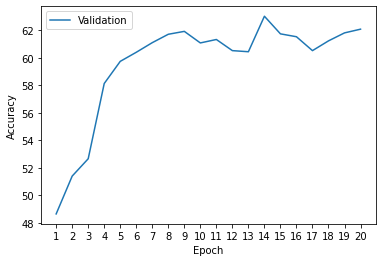

In [0]:
plt.plot(np.arange(1, args_epochs+1), valid_acc_list, label='Validation')
plt.xticks(np.arange(1, args_epochs+1))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# Batch normalization & Weight initialization

# Training settings
args_batch_size = 64
args_test_batch_size = 1000
args_epochs = 20
args_lr = 0.001
args_momentum = 0.9
args_decay = 5e-4
args_seed = 1
args_log_interval = 2500
args_no_cuda = False
args_cuda = not args_no_cuda and torch.cuda.is_available()

torch.manual_seed(args_seed)
if args_cuda:
    torch.cuda.manual_seed(args_seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args_cuda else {}
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO: define your network here 
            
        self.conv1 = nn.Conv2d(3, 6, 5)
        nn.init.kaiming_normal_(self.conv1.weight)     
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)

        # BatchNorm api provided by pytorch
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2_bn = nn.BatchNorm1d(84)
        
    def forward(self, x):
        # TODO 
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        
        return x

model = Net()
if args_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args_lr, momentum=args_momentum, weight_decay=args_decay)

train_loss_list = []
test_loss_list  = []
valid_acc_list  = []

def train(epoch):
    model.train()
    loss_sum = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        # use cross_entropy here, since there is no softmax function in my last layer
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args_log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
        
        loss_sum += loss.data
        total += 1
        
    train_loss_list.append(loss_sum / total)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # preserve the accuracy for plot and comparison
    test_loss_list.append(test_loss)
    valid_acc_list.append(100. * correct / len(test_loader.dataset))


for epoch in range(1, args_epochs + 1):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.520515
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.905357
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.700011
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.226525
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.197405

Test set: Average loss: 1.5244, Accuracy: 4622/10000 (46%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.549897
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.728977
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.835694
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.861720
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.308239

Test set: Average loss: 1.4096, Accuracy: 5144/10000 (51%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.976485
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.665158
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.864895
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2.067029
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.231465

Test set: Average loss: 1.3504, Accuracy: 5244/10000 (52%)

Train 

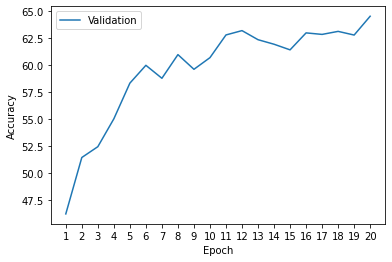

In [0]:
plt.plot(np.arange(1, args_epochs+1), valid_acc_list, label='Validation')
plt.xticks(np.arange(1, args_epochs+1))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Batch normalization & Weight initialization

# Try other ideas:
# - Data Augmentation, using RandomHorizontalFlip and RandomCrop Transfroms
# - Adam optimizer
# - Different normalization methods, including GroupNorm/InstanceNorm/LayerNorm, the test accuary doesn't improve

# Training settings
# Training settings
args_batch_size = 64
args_test_batch_size = 1000
args_epochs = 20
args_lr = 0.001
args_momentum = 0.9
args_decay = 5e-4
args_seed = 1
args_log_interval = 2500
args_no_cuda = False
args_cuda = not args_no_cuda and torch.cuda.is_available()

torch.manual_seed(args_seed)
if args_cuda:
    torch.cuda.manual_seed(args_seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args_cuda else {}
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
# Add RandomHorizontalFlip and RandomCrop here
transform=transforms.Compose([transforms.RandomHorizontalFlip(),
                              transforms.RandomCrop(size=[32,32], padding=4),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO: define your network here 
            
        self.conv1 = nn.Conv2d(3, 6, 5)
        nn.init.kaiming_normal_(self.conv1.weight)     
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)

        self.drop = nn.Dropout(0.8)

        # BatchNorm api provided by pytorch
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2_bn = nn.BatchNorm1d(84)

        # Other normalization methods
        #self.conv1_in = nn.InstanceNorm2d(6)
        #self.conv2_in = nn.InstanceNorm2d(16)
        #self.fc1_in = nn.InstanceNorm2d(120)
        #self.fc2_in = nn.InstanceNorm2d(84)

        #self.gn = nn.GroupNorm(3, 6)
        
    def forward(self, x):
        # TODO 
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        
        x = x.view(-1, 16 * 5 * 5)
        #x = self.drop(x)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        #x = self.drop(x)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        
        return x

model = Net()
if args_cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args_lr, weight_decay=args_decay)

train_loss_list = []
test_loss_list  = []
valid_acc_list  = []

def train(epoch):
    model.train()
    loss_sum = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        # use cross_entropy here, since there is no softmax function in my last layer
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args_log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
        
        loss_sum += loss.data
        total += 1
        
    train_loss_list.append(loss_sum / total)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # preserve the accuracy for plot and comparison
    test_loss_list.append(test_loss)
    valid_acc_list.append(100. * correct / len(test_loader.dataset))


for epoch in range(1, args_epochs + 1):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.319258
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.122249
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.400997
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.711243
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.157816

Test set: Average loss: 1.6004, Accuracy: 4213/10000 (42%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.467310
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.723062
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2.170473
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.762385
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.377716

Test set: Average loss: 1.5176, Accuracy: 4700/10000 (47%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.649435
Train Epoch: 3 [10000/50000 (20%)]	Loss: 2.026664
Train Epoch: 3 [20000/50000 (40%)]	Loss: 2.037837
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2.024218
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.432350

Test set: Average loss: 1.4527, Accuracy: 4890/10000 (49%)

Train 